#**IMPORTS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GRIP/yahoo.csv")
apple_training_complete = data1

#**PART 1 - VISUAL ANALYSIS**

In [108]:
!pip install pmdarima

In [109]:
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

In [110]:
print(data1.head())
print(data1.size)

         Date    Open    High     Low   Close  Adj Close  Volume
0  2001-01-02  1.4375  1.5625  1.3125  1.4375   1.294107   26600
1  2001-01-03  1.4375  1.4375  1.4375  1.4375   1.294107   18300
2  2001-01-04  1.3125  1.5625  1.3125  1.5000   1.350373   17700
3  2001-01-05  1.5000  1.6875  1.5000  1.6875   1.519169   13000
4  2001-01-08  1.6875  2.0000  1.6875  2.0000   1.800497   60200
35882


In [111]:
#Converting Date column to datetime datatype
data1['Date'] = pd.to_datetime(data1['Date'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5126 entries, 0 to 5125
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5126 non-null   datetime64[ns]
 1   Open       5126 non-null   float64       
 2   High       5126 non-null   float64       
 3   Low        5126 non-null   float64       
 4   Close      5126 non-null   float64       
 5   Adj Close  5126 non-null   float64       
 6   Volume     5126 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 280.5 KB


Text(0, 0.5, 'Close')

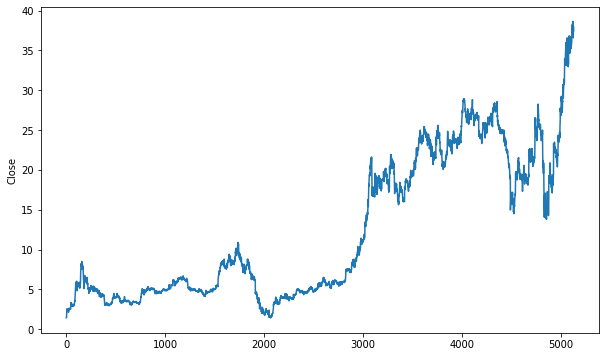

In [112]:
data1.dropna(inplace = True)
plt.figure(figsize=(10, 6))
data1['Close'].plot()
plt.ylabel('Close')

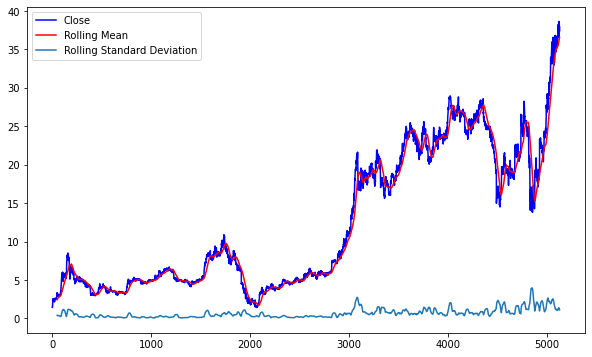

In [113]:
#Plotting moving average
close = data1['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
data1['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

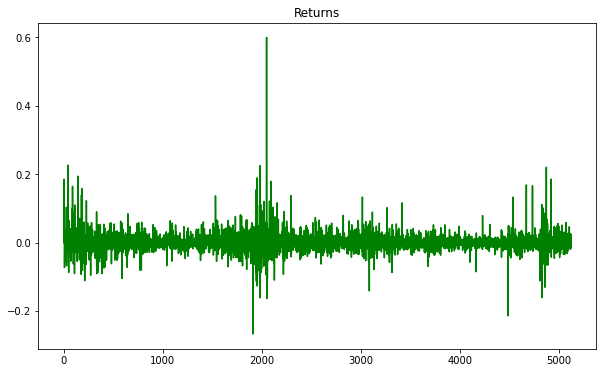

In [114]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [115]:
train = data1[:1000]
test = data1[1000:]

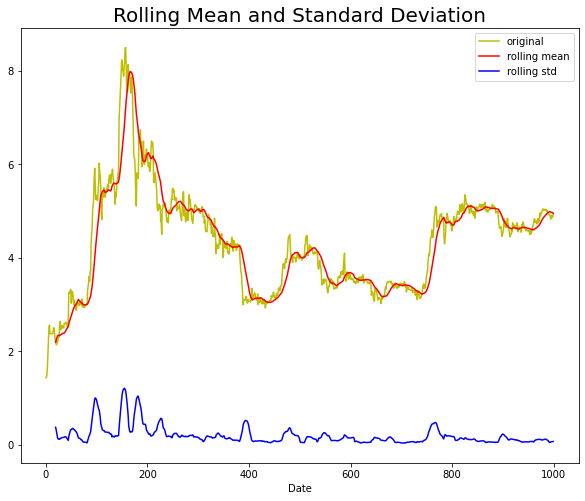

Results of dickey fuller test
ADF Test Statistic : -2.482078498110057
p-value : 0.11989593316783526
#Lags Used : 7
Number of Observations Used : 992
Weak evidence against null hypothesis, time series is non-stationary 


In [116]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

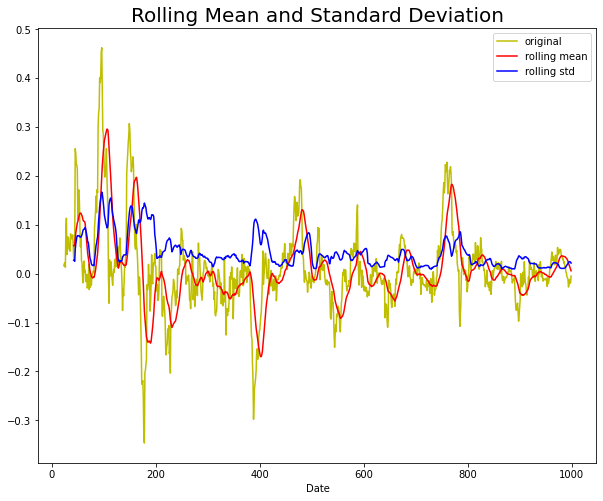

Results of dickey fuller test
ADF Test Statistic : -6.188168739501953
p-value : 6.21566068944199e-08
#Lags Used : 7
Number of Observations Used : 969
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [117]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 

train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

#**PART 2 - USING KERAS**

In [137]:
data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1.4375,1.5625,1.3125,1.4375,1.294107,26600
1,2001-01-03,1.4375,1.4375,1.4375,1.4375,1.294107,18300
2,2001-01-04,1.3125,1.5625,1.3125,1.5000,1.350373,17700
3,2001-01-05,1.5000,1.6875,1.5000,1.6875,1.519169,13000
4,2001-01-08,1.6875,2.0000,1.6875,2.0000,1.800497,60200


In [138]:
# Filtered Dataset
apple_training_processed = apple_training_complete.iloc[:, 1:2].values

In [139]:
# Data Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

apple_training_scaled = scaler.fit_transform(apple_training_processed)

In [140]:
rows, cols = data1.shape
rows

5126

In [141]:
# Convert Training Data to Right Shape
features_set = []
labels = []

features_set.append(apple_training_scaled[i-60:i, 0])
labels.append(apple_training_scaled[i, 0])

In [142]:
# Convert lists to the numpy array
features_set, labels = np.array(features_set), np.array(labels)

In [145]:
# convert data into three-dimensional format
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [146]:
# Training The LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [147]:
# instantiate the Sequential class
model = Sequential()

In [148]:
# Creating LSTM and Dropout Layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[0], 1)))

In [149]:
# Add a dropout layer to model
model.add(Dropout(0.2))

In [150]:
# Add 3 More dropout layers to model
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

In [151]:
# Creating Dense Layer
model.add(Dense(units = 1))

In [152]:
# Model Compilation
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [153]:
# Algorithm Training
model.fit(features_set, labels, epochs = 5, batch_size = 32)

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.0021
Epoch 2/5
1/1 [==============================] - 0s 95ms/step - loss: 6.8794e-04
Epoch 3/5
1/1 [==============================] - 0s 90ms/step - loss: 4.2513e-05
Epoch 4/5
1/1 [==============================] - 0s 87ms/step - loss: 2.1542e-04
Epoch 5/5
1/1 [==============================] - 0s 88ms/step - loss: 1.1785e-04


In [154]:
# Testing our LSTM
Test_path = "/content/drive/MyDrive/Colab Notebooks/GRIP/yahoo.csv"
apple_testing_complete = pd.read_csv(Test_path)
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values

In [155]:
# Converting Test Data to Right Format
apple_total = pd.concat((apple_training_complete['Open'], apple_testing_complete['Open']), axis=0)

In [156]:
# Fetching training set
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values

In [157]:
# Scale test data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [158]:
# Prepare final test input set
test_features = []

test_features.append(test_inputs[i-60:i, 0])

In [159]:
# Convert data into the three-dimensional format
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [160]:
# Making Predictions
predictions = model.predict(test_features)

In [162]:
# Reverse the scaled prediction back to their actual values
predictions = scaler.inverse_transform(predictions)
predictions

array([[267.6062]], dtype=float32)

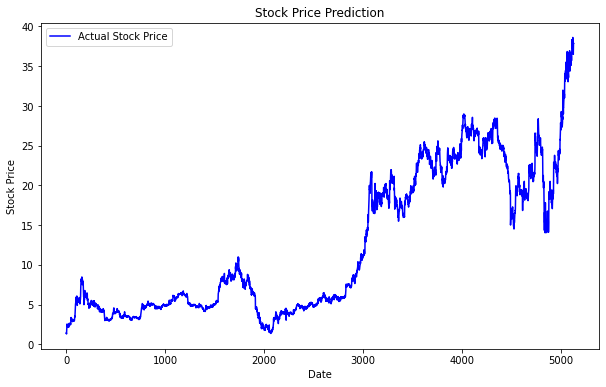

In [166]:
# Conclusion - Plot
plt.figure(figsize=(10,6))
plt.plot(apple_testing_processed, color='blue', label='Actual Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#**PART 3 - TEXTUAL ANALYSIS**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer as ps
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
cols = ['Date','Category','News']

data2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GRIP/india-news-headlines.csv", names= cols)
df_news = data2
df_news.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [ ]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [ ]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-12-31,Govt extends deadline for use of FASTag till F...


In [ ]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [ ]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7257    #BigInterview! Dhritiman Chatterjee: Nobody da...
7258    Horoscope Today; 28 December 2020: Check astro...
7259    Man recovers charred remains of 'thief' from h...
7260    Numerology Readings 30 December 2020: Predicti...
7261    Horoscope Today; 31 December 2020: Check astro...
Name: News, Length: 7262, dtype: object

In [ ]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    #news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [ ]:
df_news['News'] = pd.Series(c)
df_news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,News
0,2001-01-02,status quo will not be disturbed at ayodhya sa...
1,2001-01-03,powerless north india gropes in the dark think...
2,2001-01-04,the string that pulled stephen hawking to indi...
3,2001-01-05,light combat craft takes india into club class...
4,2001-01-06,light combat craft takes india into club class...
...,...,...
7257,2020-12-27,biginterview dhritiman chatterjee nobody dares...
7258,2020-12-28,horoscope today december check astrological pr...
7259,2020-12-29,man recovers charred remains of thief from his...
7260,2020-12-30,numerology readings december predictions lucky...


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity
  
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496


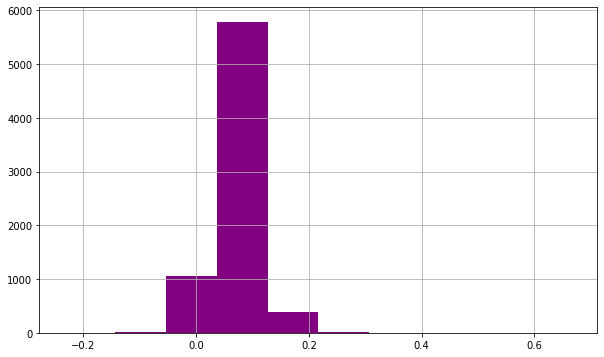

In [ ]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

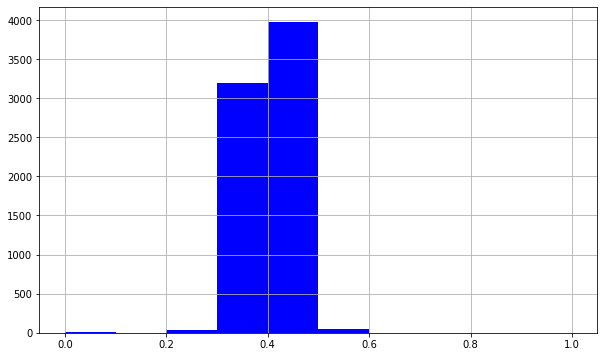

In [ ]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

**Adding sentiment score to df_news**

In [ ]:

sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886,-0.9997,0.126,0.798,0.076
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.137,0.771,0.092
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.148,0.758,0.094
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.141,0.780,0.079


In [119]:
df_merge = pd.merge(data1, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,1.437500,1.562500,1.312500,1.437500,1.294107,26600,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,1.437500,1.437500,1.437500,1.437500,1.294107,18300,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,1.312500,1.562500,1.312500,1.500000,1.350373,17700,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,1.500000,1.687500,1.500000,1.687500,1.519169,13000,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-08,1.687500,2.000000,1.687500,2.000000,1.800497,60200,Sangh Parivar; Babri panel up the ante Frontru...,0.414653,-0.019214,-0.9779,0.121,0.812,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999,2020-12-24,30.709999,30.950001,30.280001,30.840000,30.672073,29900,How to set the mood for sex during cold winter...,0.390942,0.048166,-0.9988,0.092,0.842,0.066
5000,2020-12-28,31.000000,31.590000,30.990000,31.400000,31.229023,86500,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.137,0.771,0.092
5001,2020-12-29,31.299999,31.750000,30.420000,30.760000,30.592508,80400,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.148,0.758,0.094
5002,2020-12-30,31.059999,31.670000,30.889999,30.940001,30.771528,46500,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.141,0.780,0.079


In [120]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,1.437500,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,1.437500,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,1.500000,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,1.687500,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2.000000,0.414653,-0.019214,-0.9779,0.121,0.812,0.066
...,...,...,...,...,...,...,...
4999,30.840000,0.390942,0.048166,-0.9988,0.092,0.842,0.066
5000,31.400000,0.412945,0.070517,-0.9998,0.137,0.771,0.092
5001,30.760000,0.424021,0.061210,-0.9999,0.148,0.758,0.094
5002,30.940001,0.441660,0.043496,-0.9999,0.141,0.780,0.079


In [121]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.000917,0.282333,0.524545,0.00945,0.274775,0.807,0.116776
1,0.000917,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
2,0.003001,0.446847,0.438129,0.93690,0.225225,0.797,0.169408
3,0.009253,0.476612,0.675488,0.98165,0.279279,0.722,0.253289
4,0.019673,0.414653,0.291981,0.01105,0.272523,0.812,0.108553


In [122]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [123]:
X.head()


,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.282333,0.524545,0.00945,0.274775,0.807,0.116776
1,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
2,0.446847,0.438129,0.93690,0.225225,0.797,0.169408
3,0.476612,0.675488,0.98165,0.279279,0.722,0.253289
4,0.414653,0.291981,0.01105,0.272523,0.812,0.108553


In [124]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

(4003, 6)

**Random Forest Regressor**

In [126]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [129]:
prediction = rf.predict(x_test)
prediction

array([0.13511693, 0.14978104, 0.12844281, ..., 0.62304991, 0.2671944 ,
       0.52921141])

In [130]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.13511693 0.14978104 0.12844281 0.34757059 0.59669446 0.11413717
 0.14131889 0.1424033  0.67247081 0.1687243 ]
1261    0.119373
939     0.110704
575     0.070690
666     0.066022
4294    0.889963
1657    0.230077
1377    0.099033
2450    0.122374
3855    0.721574
2590    0.152051
Name: Close, dtype: float64
0.03179597757338631


**XGboost Regressor**

In [131]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[15:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [132]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.03502290155708062


**Logestic Regressor**

In [133]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [134]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.1603868  0.13704568 0.17372457 0.11103701 0.24208069 0.07169056
 0.11437146 0.07402467 0.79993331 0.12637546]
1261    0.119373
939     0.110704
575     0.070690
666     0.066022
4294    0.889963
1657    0.230077
1377    0.099033
2450    0.122374
3855    0.721574
2590    0.152051
Name: Close, dtype: float64
0.0636346289099957
